In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff

In [3]:
dataset_acquisition =tiff.imread("examples/FF_dataset_acquisitions.tiff")

In [7]:
dataset_acquisition = dataset_acquisition[:, :100]
num_frames = dataset_acquisition.shape[0]
num_samples = dataset_acquisition.shape[1]

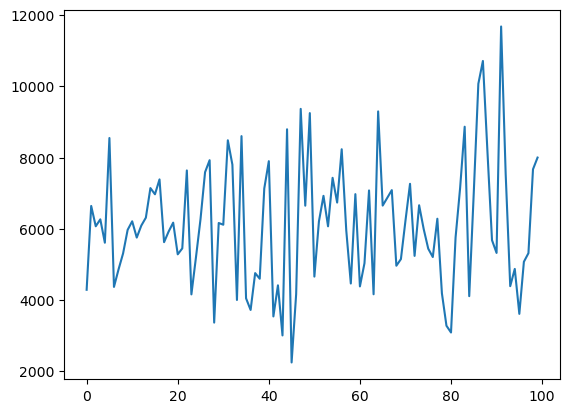

In [8]:
plt.plot(dataset_acquisition[0])

In [9]:
# Define camera noise settings in a dictionary
camera_noise_settings = {
    'QE': 0.9,
    'sigma_R': 10,
    'c': 0.002,
    'EM_gain': 500,
    'e_adu': 10,
    'BL': 100
}


(90, 100)

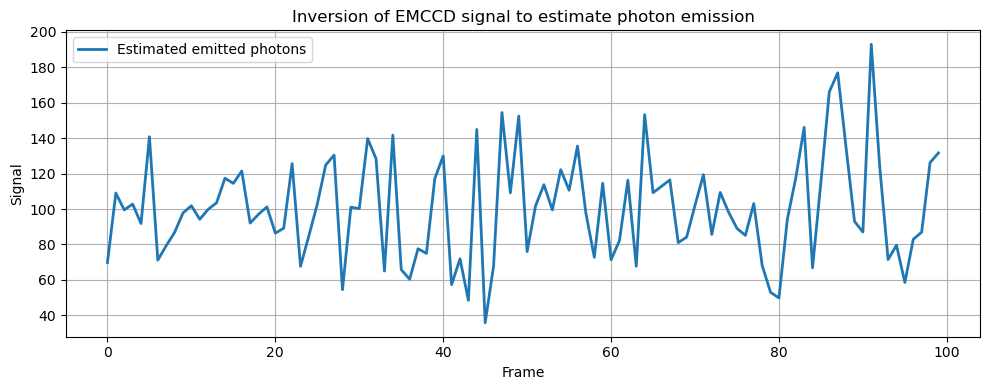

In [21]:
import numpy as np

import numpy as np
from skimage.restoration import denoise_wavelet

def invert_emccd_signal(
    frame_adu: np.ndarray,
    em_gain: float = 300,
    read_noise_std: float = 1.5,
    e_per_adu: float = 5.0,
    baseline: float = 100
) -> np.ndarray:
    """
    Approximate the number of emitted photons from an EMCCD-acquired image
    using a physics-aware, layered denoising approach.
    
    Parameters:
        frame_adu (np.ndarray): Input digitized EMCCD frame (ADU units)
        em_gain (float): EM gain (multiplicative amplifier)
        read_noise_std (float): Standard deviation of Gaussian read noise (in electrons)
        e_per_adu (float): Conversion factor (electrons per ADU)
        baseline (float): Camera baseline (in ADU)
    
    Returns:
        np.ndarray: Approximate number of photoelectrons before amplification
    """
    
    # Step 1: Remove baseline and clip to non-negative values
    adu_corrected = np.maximum(frame_adu - baseline, 0)

    # Step 2: Convert ADU to electrons
    electrons = adu_corrected * e_per_adu

    # Step 3: Denoise Gaussian read noise using wavelet denoising
    electrons_denoised = denoise_wavelet(
        electrons,
        sigma=read_noise_std,
        mode='soft',
        method='BayesShrink',
        rescale_sigma=True,
        channel_axis=None
    )

    # Step 4: Normalize by EM gain to estimate Poisson signal
    estimated_photoelectrons = electrons_denoised / em_gain

    return estimated_photoelectrons



# Assume you have: frame_adu from apply_camera_advanced(...)
estimated_photons = invert_emccd_signal(dataset_acquisition[0])

# Plot to compare raw vs denoised
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
# plt.plot(dataset_acquisition[0], label="Raw EMCCD signal (ADU)", alpha=0.7)
plt.plot(estimated_photons, label="Estimated emitted photons", linewidth=2)
plt.xlabel("Frame")
plt.ylabel("Signal")
plt.legend()
plt.title("Inversion of EMCCD signal to estimate photon emission")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
import numpy as np

def estimate_epsilon_from_trace(estimated_photons, power_Wcm2, wavelength_nm, frame_duration):
    # Constants
    NA = 6.022e23  # Avogadro number
    h = 6.626e-34  # Planck constant
    c = 3.0e8      # Speed of light
    ln10 = np.log(10)

    # Estimate excitation rate (photons/s)
    k01_hat = np.mean(estimated_photons) / frame_duration

    # Convert wavelength from nm to m
    wavelength_m = wavelength_nm * 1e-9

    # Apply MUFASA inversion formula
    epsilon = (k01_hat * NA * h * c) / (power_Wcm2 * wavelength_nm * 1e-6 * ln10)
    return epsilon, k01_hat

# Example values
frame_duration = 0.1  # seconds
laser_power = 2.0      # W/cm²
excitation_lambda = 488  # nm

# estimated_photons = invert_emccd_signal(frame_adu)  # use your real signal
epsilon_est, k01_est = estimate_epsilon_from_trace(
    estimated_photons, power_Wcm2=laser_power, wavelength_nm=excitation_lambda, frame_duration=frame_duration
)

print(f"Estimated ε: {epsilon_est:,.0f} M⁻¹·cm⁻¹")
print(f"Estimated k01: {k01_est:.2e} s⁻¹")


Estimated ε: 53,558 M⁻¹·cm⁻¹
Estimated k01: 1.01e+03 s⁻¹


In [23]:
import numpy as np
from skimage.restoration import denoise_wavelet

# Physical constants
NA = 6.02214076e23     # Avogadro's number (mol⁻¹)
h = 6.62607015e-34     # Planck constant (J·s)
c = 2.99792458e8       # Speed of light (m/s)
ln10 = np.log(10)

def anscombe_transform(x):
    """Apply Anscombe variance-stabilizing transform for Poisson noise."""
    return 2.0 * np.sqrt(x + 3.0 / 8.0)

def inverse_anscombe(y):
    """Inverse of the Anscombe transform (approximate)."""
    return (y / 2.0) ** 2 - 3.0 / 8.0

def invert_emccd_signal_with_poisson_denoising(
    frame_adu: np.ndarray,
    em_gain: float = 300,
    read_noise_std: float = 1.5,
    e_per_adu: float = 5.0,
    baseline: float = 100
) -> np.ndarray:
    """
    Physics-aware denoising: estimate photon emissions from EMCCD ADUs.
    """
    # Step 1: Remove baseline, convert ADUs to electrons
    adu_corrected = np.maximum(frame_adu - baseline, 0)
    electrons = adu_corrected * e_per_adu

    # Step 2: Denoise Gaussian readout noise (wavelet)
    electrons_denoised = denoise_wavelet(
        electrons,
        sigma=read_noise_std,
        mode='soft',
        method='BayesShrink',
        rescale_sigma=True,
        channel_axis=None
    )

    # Step 3: Invert EM gain (remove gamma multiplicative noise)
    photoelectrons = np.maximum(electrons_denoised / em_gain, 0)

    # Step 4: Anscombe transform for Poisson denoising
    vst = anscombe_transform(photoelectrons)

    # Step 5: Denoise stabilized signal (wavelet)
    vst_denoised = denoise_wavelet(
        vst,
        mode='soft',
        method='BayesShrink',
        rescale_sigma=True,
        channel_axis=None
    )

    # Step 6: Inverse Anscombe to get denoised photon emission estimate
    return np.maximum(inverse_anscombe(vst_denoised), 0)

def estimate_epsilon(
    k01_hat: float,  # excitation rate (s⁻¹)
    P: float,        # excitation power density (W/cm²)
    wavelength_nm: float = 488
) -> float:
    """
    Estimate the molar extinction coefficient ε using Equation (1).
    
    ε = (k01_hat * NA * h * c) / (P * λ * 10⁻⁶ * ln(10))
    
    Args:
        k01_hat (float): estimated excitation rate (s⁻¹)
        P (float): excitation power density in W/cm²
        wavelength_nm (float): excitation wavelength in nm

    Returns:
        epsilon (float): molar extinction coefficient (M⁻¹·cm⁻¹)
    """
    λ_m = wavelength_nm * 1e-9
    P_W_m2 = P * 1e4  # convert W/cm² to W/m²
    epsilon = (k01_hat * NA * h * c) / (P_W_m2 * λ_m * ln10)
    return epsilon


In [ ]:

frame = dataset_acquisition[0] # shape: (T,) or (H, W)

# Step 1: Denoise the signal
denoised_photons = invert_emccd_signal_with_poisson_denoising(frame)

# Step 2: Estimate average excitation rate (photons/s)
total_photons = np.sum(denoised_photons)
duration = 1000  # seconds, or total time of acquisition
k01_hat = total_photons / duration  # excitation rate

# Step 3: Estimate epsilon
estimated_eps = estimate_epsilon(k01_hat, P=2.0, wavelength_nm=488)
print(f"Estimated ε: {estimated_eps} M⁻¹·cm⁻¹")

Estimated ε: 52.522298923238004 M⁻¹·cm⁻¹
